<a href="https://colab.research.google.com/github/dmachlanski/ncrm-causality-2021/blob/main/labs/day_1/Tutorial_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression - tutorial

This is a guided example that involves a regression problem - [abalone](https://archive.ics.uci.edu/ml/datasets/abalone) dataset.

## The plan
1. Import necessary packages.
2. Load and explore the dataset.
3. Perform data pre-processing (transformations, scaling, splitting).
4. Train and evaluate the models.
5. Hyperparameter optimisation.

## Step 1 - packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Step 2 - data

More information about the covariates:

| Name           | Data Type  | Measurement Unit | Description                 |
|----------------|------------|------------------|-----------------------------|
| Sex            | nominal    | -                | M, F, and I (infant)        |
| Length         | continuous | mm               | longest shell measurement   |
| Diameter       | continuous | mm               | perpendicular to length     |
| Height         | continuous | mm               | with meat in shell          |
| Whole weight   | continuous | grams            | whole abalone               |
| Shucked weight | continuous | grams            | weight of meat              |
| Viscera weight | continuous | grams            | gut weight (after bleeding) |
| Shell weight   | continuous | grams            | after being dried           |
| Rings          | integer    | -                | +1.5 gives the age in years |

In [2]:
df_data = pd.read_csv('https://raw.githubusercontent.com/dmachlanski/ncrm-causality-2021/main/labs/day_1/data/abalone.csv')

In [3]:
df_data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10):
    sq = math.sqrt(data.shape[1])
    d_ceil = math.ceil(sq)
    d_floor = math.floor(sq)

    if (d_ceil * d_floor) >= data.shape[1]:
        n_rows = d_floor
        n_cols = d_ceil
    else:
        n_rows = n_cols = d_ceil

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))
    axs = _trim_axs(axs, data.shape[1])

    for i, ax in enumerate(axs):
        ax.hist(data[:, i], bins=bins)
    
    fig.tight_layout()
    plt.show()

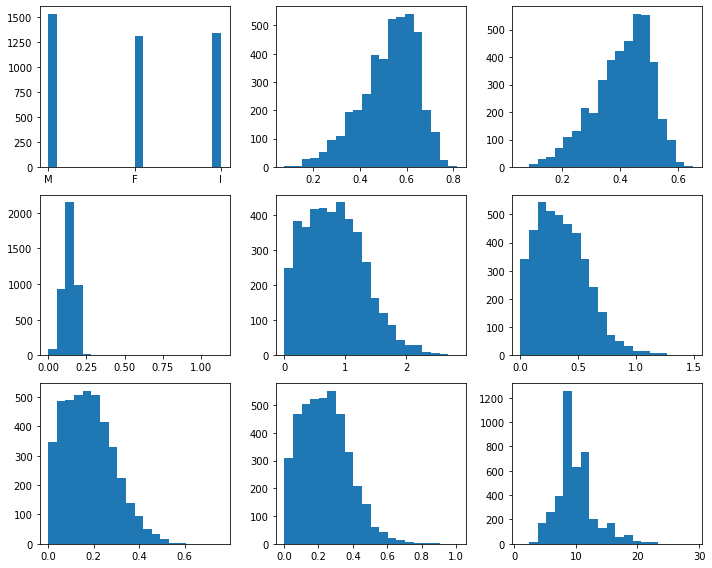

In [5]:
plot_dist(df_data.to_numpy(), 20)

## Step 3 - data pre-processing

1. Transform categorical variable 'Sex' to one-hot representation.
2. Separate background covariates (X) from the target (y).
3. Split into training and testing data.
4. Scale the data.

In [6]:
df_data_new = pd.get_dummies(df_data, columns=['sex'], drop_first=True)
df_data_new.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0


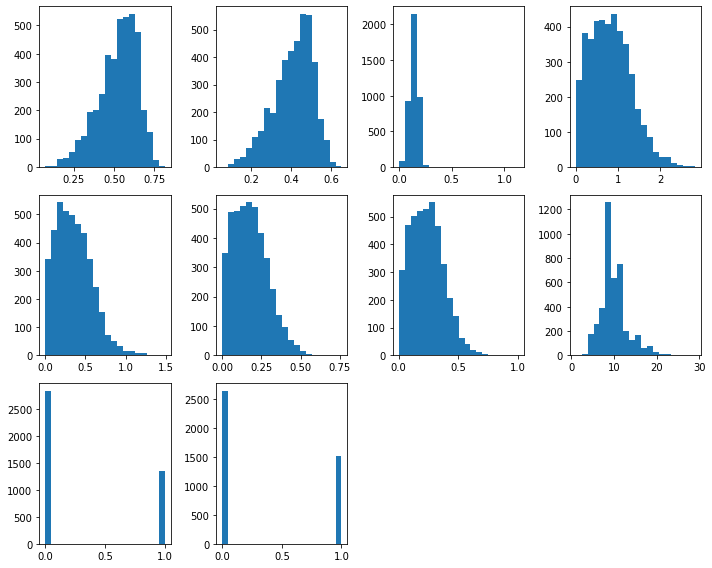

In [7]:
plot_dist(df_data_new.to_numpy(), 20)

In [8]:
X = df_data_new.drop(columns=['rings']).to_numpy()
y = df_data_new['rings'].to_numpy()

In [9]:
print(X.shape)
print(y.shape)

(4177, 9)
(4177,)


In [10]:
y = y.reshape(-1, 1)
print(y.shape)

(4177, 1)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler_x = MinMaxScaler()

scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)

X_test = scaler_x.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3341, 9)
(3341, 1)
(836, 9)
(836, 1)


## Step 4 - train the models

1. Dummy model (sanity check).
2. Linear regression.
3. Decision tree.
4. Random forest.

For each of the above, we do the following:
1. Fit the model on the training data (X and y).
2. Make predictions for the test data (X).
3. Compare obtained predictions to the ground truth (y).

We will use the Mean Squared Error (MSE) metric to evaluate our models' performance.

$$MSE = \frac{1}{n} \sum \limits_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [12]:
dr = DummyRegressor()
dr.fit(X_train, y_train)

y_pred_test = dr.predict(X_test)

dr_mse_test = mean_squared_error(y_test, y_pred_test)

print(dr_mse_test)

12.056335135912175


In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

lr_mse_test = mean_squared_error(y_test, y_pred_test)

print(lr_mse_test)

5.317967022794526


In [14]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_test = dt.predict(X_test)

dt_mse_test = mean_squared_error(y_test, y_pred_test)

print(dt_mse_test)

9.629186602870814


In [15]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train.flatten())

y_pred_test = rf.predict(X_test)

rf_mse_test = mean_squared_error(y_test, y_pred_test)

print(rf_mse_test)

5.270041866028708


Compare all obtained results to each other

In [16]:
print(f'Dummy: {dr_mse_test}')
print(f'LR: {lr_mse_test}')
print(f'DT: {dt_mse_test}')
print(f'RF: {rf_mse_test}')

Dummy: 12.056335135912175
LR: 5.317967022794526
DT: 9.629186602870814
RF: 5.270041866028708


## Step 5 - hyperparameter tuning

1. Manual search via cross-validation.
2. More automated approach with GridSearchCV.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

### Manual

In [20]:
# max_depth, max_leaf_nodes
dt_cv = DecisionTreeRegressor(max_depth=5, min_samples_split=5)
score = cross_val_score(dt_cv, X_train, y_train, cv=10)

print(score)
print(score.mean())
print(score.std())

[0.47637243 0.50254338 0.34601667 0.50737247 0.46099976 0.47343082
 0.44850109 0.42405368 0.47323319 0.4883807 ]
0.4600904188235768
0.04461008454202712


### GridSearchCV

In [21]:
dt_gs = DecisionTreeRegressor()
params = {'max_depth': [1, 2, 5, 10, 20, None], 'max_leaf_nodes': [2, 5, 10, 20, 30, None]}
gs_cv = GridSearchCV(dt_gs, cv=10, param_grid=params)

gs_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 5, 10, 20, None],
                         'max_leaf_nodes': [2, 5, 10, 20, 30, None]},
             pre_disp

In [22]:
gs_cv.best_params_

{'max_depth': 5, 'max_leaf_nodes': 30}

In [23]:
gs_cv.best_score_

0.46058208797022643

In [24]:
y_pred_test = gs_cv.predict(X_test)

gs_mse_test = mean_squared_error(y_test, y_pred_test)

print(gs_mse_test)

6.7184684888698945


In [25]:
print(f'Dummy: {dr_mse_test}')
print(f'LR: {lr_mse_test}')
print(f'DT: {dt_mse_test}')
print(f'RF: {rf_mse_test}')

Dummy: 12.056335135912175
LR: 5.317967022794526
DT: 9.629186602870814
RF: 5.270041866028708
